Author: Justus Renkhoff

# Import required libraries and modules

In [33]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow as tf
import keras
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.layers import Lambda
from PIL import Image
import cv2
from tensorflow.keras import layers
from keras.utils import to_categorical
import matplotlib.pyplot as plt


# Create a custom generator

I build a custom generator so that not all images are loaded into the memory at once

In [2]:
class CustomGenerator(keras.utils.Sequence):
    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size: (idx + 1) * self.batch_size]        
        return np.array([
            (cv2.imread(str(file_name)))
            for file_name in batch_x]), np.array(batch_y)

# Function to plot learning curve

In [34]:
def create_plot(model, model_name):
    loss_train = model.history.history['accuracy']
    loss_val = model.history.history['val_accuracy']
    epochs = range(1, 7)
    plt.plot(epochs, loss_train, 'g', label='Training accuracy')
    plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(model_name + '.png')


# Load the data

In [3]:
path = Path("test_data_smaller")
df = pd.read_csv(path/'artists.csv')

# Check the distribution of the data

In [4]:
artists_df = df[['name', 'paintings']].groupby(['name'], as_index = False).sum()
names = artists_df.sort_values('paintings', ascending = False)[:50]
print(names)

                         name  paintings
48           Vincent van Gogh        877
10                Edgar Degas        702
33              Pablo Picasso        439
38      Pierre-Auguste Renoir        336
0              Albrecht Dürer        328
35               Paul Gauguin        311
15             Francisco Goya        291
42                  Rembrandt        262
1               Alfred Sisley        259
46                     Titian        255
30               Marc Chagall        239
43              Rene Magritte        194
2           Amedeo Modigliani        193
36                  Paul Klee        188
21              Henri Matisse        186
4                 Andy Warhol        181
32             Mikhail Vrubel        171
45          Sandro Botticelli        164
29          Leonardo da Vinci        143
37          Peter Paul Rubens        141
44              Salvador Dali        139
24           Hieronymus Bosch        137
40             Pieter Bruegel        134
9             Di

# Create a list with all paintings and artists

In [5]:
images_dir = Path(path/'images/images')

painting_list = []
for path, subdirs, files in os.walk(images_dir):
    for name in files:
        img = os.path.join(path, name)
        painting_list.extend([img])

#only works on windows
artist_list = []
for painting in painting_list:
    artist = painting.split('\\')[3]
    artist_list.extend([artist])

# Create X and y

In [6]:
y = np.array(artist_list)  

encoder = LabelEncoder()
y = encoder.fit_transform(pd.Series(y))
classes = list(encoder.classes_)
for i in range(len(classes)):
    print(i, ' represents ', classes[i])

y = keras.utils.to_categorical(y, len(classes))
print(y)

X = np.array(painting_list) 

0  represents  Francisco_Goya
1  represents  Paul_Gauguin
2  represents  Pierre-Auguste_Renoir
3  represents  Rembrandt
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


# Split data into train, validation and test data

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=1)

# Prepare generators for training

In [8]:
batch_size = 16
training_batch_generator = CustomGenerator(X_train, y_train, batch_size)
validation_batch_generator = CustomGenerator(X_val, y_val, batch_size)
training_size = len(X_train)
validation_size = len(X_val)
test_size = len(X_test)
input_shape = (cv2.imread(str(painting_list[0]))).shape
print(input_shape)

(224, 224, 3)


# A model based on VGG-16's architecture
https://github.com/ashushekar/VGG16

In [9]:
def make_vgg16_model(input_shape, num_classes):
    # Generate the model
    model = Sequential()

    # Layer 1: Convolutional
    model.add(Conv2D(input_shape=input_shape, filters=64, kernel_size=(3, 3),
                     padding='same', activation='relu'))

    # Layer 2: Convolutional
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))

    # Layer 3: MaxPooling
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    # Layer 4: Convolutional
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
    # Layer 5: Convolutional
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
    # Layer 6: MaxPooling
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    # Layer 7: Convolutional
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
    # Layer 8: Convolutional
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
    # Layer 9: Convolutional
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
    # Layer 10: MaxPooling
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    # Layer 11: Convolutional
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
    # Layer 12: Convolutional
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
    # Layer 13: Convolutional
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
    # Layer 14: MaxPooling
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    # Layer 15: Convolutional
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
    # Layer 16: Convolutional
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
    # Layer 17: Convolutional
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
    # Layer 18: MaxPooling
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    # Layer 19: Flatten
    model.add(Flatten())
    # Layer 20: Fully Connected Layer
    model.add(Dense(units=4096, activation='relu'))
    # Layer 21: Fully Connected Layer
    model.add(Dense(units=4096, activation='relu'))
    # Layer 22: Softmax Layer
    model.add(Dense(units=num_classes, activation='softmax'))
    print(model.summary())
    return model

# A model based on an image classification tutorial by keras
https://keras.io/examples/vision/image_classification_from_scratch/

In [10]:
def make_keras_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    activation = "softmax"

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation=activation)(x)
    return keras.Model(inputs, outputs)

# Train keras-like model

In [11]:
model_keras = make_keras_model(input_shape, len(classes))
print(model_keras.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 12  3584        ['rescaling[0][0]']              
                                8)                                                                
                                                                                              

In [12]:
model_keras.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model_keras.fit_generator(generator=training_batch_generator,
                    steps_per_epoch=int(training_size // batch_size),
                    epochs=6,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=int(validation_size // batch_size)
                   )

Epoch 1/6


C:\Users\justu\AppData\Local\Temp\ipykernel_16208\1483329134.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_keras.fit_generator(generator=training_batch_generator,


60/60 [==============================] - 161s 3s/step - loss: 1.0680 - accuracy: 0.5885 - val_loss: 1.3778 - val_accuracy: 0.2321
Epoch 2/6
60/60 [==============================] - 153s 3s/step - loss: 0.9381 - accuracy: 0.6365 - val_loss: 1.3956 - val_accuracy: 0.3393
Epoch 3/6
60/60 [==============================] - 154s 3s/step - loss: 0.8311 - accuracy: 0.6750 - val_loss: 1.5520 - val_accuracy: 0.1875
Epoch 4/6
60/60 [==============================] - 154s 3s/step - loss: 0.7720 - accuracy: 0.6948 - val_loss: 1.7119 - val_accuracy: 0.1875
Epoch 5/6
60/60 [==============================] - 159s 3s/step - loss: 0.7227 - accuracy: 0.7104 - val_loss: 1.8820 - val_accuracy: 0.2589
Epoch 6/6
60/60 [==============================] - 160s 3s/step - loss: 0.6288 - accuracy: 0.7615 - val_loss: 2.5438 - val_accuracy: 0.1875


In [13]:
model_keras.save(Path('model_keras_test_smaller.h5'))

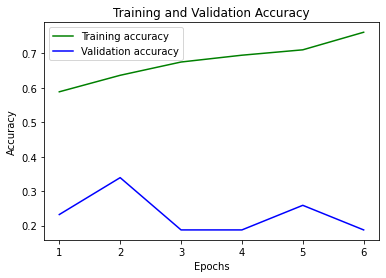

In [30]:
create_plot(model_keras, 'model_keras_test_smaller')

# Train VGG16-like model

In [14]:
model_vgg16 = make_vgg16_model(input_shape, len(classes))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [15]:
model_vgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model_vgg16.fit_generator(generator=training_batch_generator,
                    steps_per_epoch=int(training_size // batch_size),
                    epochs=6,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=int(validation_size // batch_size)
                   )

Epoch 1/6


C:\Users\justu\AppData\Local\Temp\ipykernel_16208\737468964.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_vgg16.fit_generator(generator=training_batch_generator,


60/60 [==============================] - 314s 5s/step - loss: 125.1766 - accuracy: 0.2635 - val_loss: 1.3824 - val_accuracy: 0.2857
Epoch 2/6
60/60 [==============================] - 309s 5s/step - loss: 1.3999 - accuracy: 0.2792 - val_loss: 1.3883 - val_accuracy: 0.2857
Epoch 3/6
60/60 [==============================] - 309s 5s/step - loss: 1.3821 - accuracy: 0.2708 - val_loss: 1.3847 - val_accuracy: 0.2857
Epoch 4/6
60/60 [==============================] - 313s 5s/step - loss: 1.4032 - accuracy: 0.2906 - val_loss: 1.6411 - val_accuracy: 0.2857
Epoch 5/6
60/60 [==============================] - 305s 5s/step - loss: 1.4022 - accuracy: 0.2781 - val_loss: 1.3607 - val_accuracy: 0.3393
Epoch 6/6
60/60 [==============================] - 302s 5s/step - loss: 1.3456 - accuracy: 0.3240 - val_loss: 1.3867 - val_accuracy: 0.2321


In [16]:
model_vgg16.save(Path('model_vgg16_test_smaller.h5'))

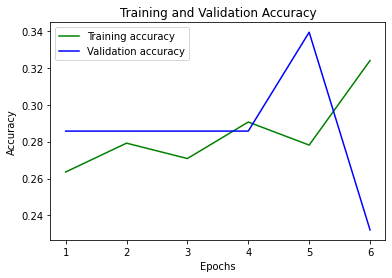

In [31]:
create_plot(model_vgg16, 'model_vgg16_test_smaller')